<a href="https://colab.research.google.com/github/CobaMasa/RStan2PyStan/blob/master/chapter5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pystan

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
path = 'drive/My Drive/Colab/RStanBook/chap05/input/data-attendance-2.txt'
data = pd.read_csv(path)
print('shape: ', data.shape)
data.head()

shape:  (50, 5)


,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23


In [0]:
data.describe()

,PersonID,A,Score,M,Y
count,50.00000,50.000000,50.000000,50.000000,50.00000
mean,25.50000,0.400000,121.700000,47.920000,34.44000
std,14.57738,0.494872,28.136874,17.953273,12.87643
min,1.00000,0.000000,51.000000,12.000000,10.00000
25%,13.25000,0.000000,105.250000,34.750000,26.00000
50%,25.50000,0.000000,120.500000,48.000000,33.50000
75%,37.75000,1.000000,142.500000,59.000000,43.00000
max,50.00000,1.000000,185.000000,88.000000,63.00000


modeling...

$$
\begin{eqnarray}
    Y[n]&〜&Bi(M[n], p[n])\\
    p[n]&〜&\frac{1}{1+e^{-(w_0+w_1A[n]+w_2Score[n])}}
\end{eqnarray}
$$

In [0]:
from google.colab import files
files.upload()

Saving model5-4.stan to model5-4.stan


{'model5-4.stan': b'data {\n  int N;\n  int<lower=0, upper=1>A[N];\n  real<lower=0, upper=1>Score[N];\n  int<lower=0> M[N];\n  int<lower=0> Y[N];\n}\n\nparameters {\n  real w0;\n  real w1;\n  real w2;\n}\n\ntransformed parameters {\n  real p[N];\n  for (n in 1:N)\n  p[n] = inv_logit(w0+w1*A[n]+w2*Score[n]);\n}\n\nmodel {\n  for (n in 1:N)\n  Y[n]~binomial(M[n], p[n]);\n}\n\ngenerated quantities {\n  real y_pred[N];\n  for (n in 1:N)\n  y_pred[n] = binomial_rng(M[n], p[n]);\n}\n'}

In [0]:
stan_data = {
    'N': data.shape[0],
    'A': data.A,
    'Score': data.Score/200,
    'M': data.M,
    'Y': data.Y
}

sm = pystan.StanModel(file='model5-4.stan')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6cecb40774da9b3a1fff064b2b609090 NOW.


In [0]:
fit = sm.sampling(data=stan_data, iter=3000, chains=4, thin=1)
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_6cecb40774da9b3a1fff064b2b609090.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w0           0.09  5.1e-3   0.22  -0.34  -0.06   0.09   0.24   0.53   1897    1.0
w1          -0.62  1.9e-3   0.09   -0.8  -0.68  -0.62  -0.55  -0.43   2499    1.0
w2            1.9  8.3e-3   0.36    1.2   1.65    1.9   2.15    2.6   1905    1.0
p[1]         0.68  5.3e-4   0.02   0.63   0.66   0.68    0.7   0.72   2085    1.0
p[2]          0.7  2.8e-4   0.02   0.67   0.69    0.7   0.71   0.73   3099    1.0
p[3]         0.78  2.0e-4   0.01   0.76   0.77   0.78   0.79    0.8   3555    1.0
p[4]         0.57  4.4e-4   0.02   0.53   0.56   0.57   0.59   0.62   2588    1.0
p[5]         0.73  3.5e-4   0.02   0.69   0.71   0.73   0.74   0.76   2612    1.0
p[6]         0.79  2.0e-4   0.01 

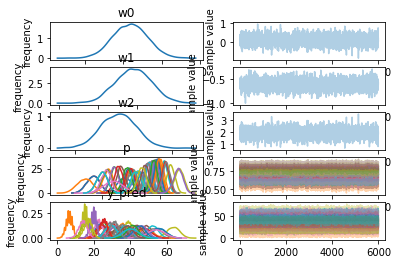

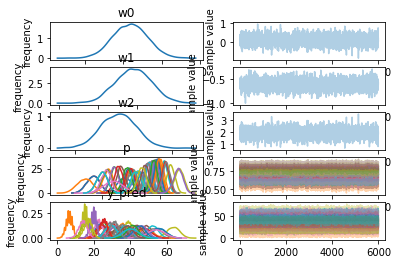

In [0]:
fit.plot()

In [0]:
# check the errs of original data and samples
M_range = np.linspace(data.M.min(), data.M.max(), 1000)


array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
       80, 81, 82, 83, 84, 85, 86, 87])

In [0]:
subset = ['A', 'Score', 'M', 'Y']
p_range = [10, 50, 90]
d_qua = np.percentile(fit.extract()['y_pred'], p_range, axis=0).T
d_qua = pd.DataFrame(np.hstack((data[subset], d_qua)), columns=subset+['p{}'.format(i) for i in p_range])
d_qua.head()

,A,Score,M,Y,p10,p50,p90
0,0.0,69.0,43.0,38.0,25.0,29.0,33.0
1,1.0,145.0,56.0,40.0,35.0,39.0,44.0
2,0.0,125.0,32.0,24.0,22.0,25.0,28.0
3,1.0,86.0,45.0,33.0,21.0,26.0,30.0
4,1.0,158.0,33.0,23.0,20.9,24.0,27.0


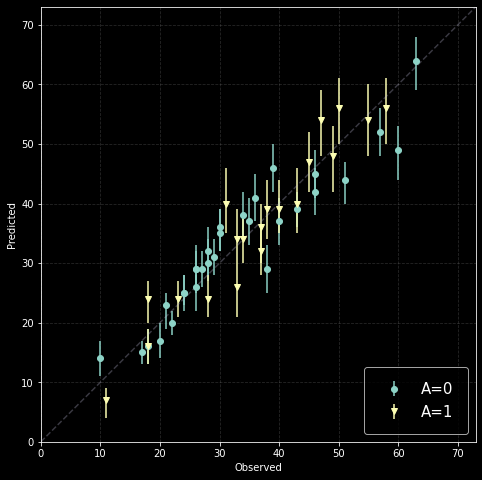

In [0]:
from matplotlib.markers import MarkerStyle
plt.style.use('dark_background')

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(aspect='equal')

for flag in d_qua.A.unique():
    d_part = d_qua.query('A=={}'.format(flag))
    err_lower = d_part['p50'] - d_part['p10']
    err_upper = d_part['p90'] - d_part['p50']
    ax.errorbar('Y', 'p50', data=d_part, yerr=[err_lower, err_upper], fmt='o',
                marker=MarkerStyle.filled_markers[int(flag)], label='A={}'.format(int(flag)))


# Adjusting...
y_range = [d_qua.Y.min()-10, d_qua.Y.max()+10]
plt.plot(y_range, y_range, alpha=0.3, ls='--')
ax.set(xlabel='Observed', ylabel='Predicted', xlim=y_range, ylim=y_range)
ax.grid(color='gray', alpha=0.3, ls='--')
plt.legend(loc='lower right', fontsize=15, borderpad=True)
plt.show();

In [0]:
# Not too bad, seeing it's almost linear relationship btw Obs & Prds